Using device: cpu

GENERATING SYNTHETIC SEISMIC DATA

--- Case Study 1: Fault Detection ---
Training Fault Detection CNN...
Epoch 5/15 | Train Loss: 193.4781 | Val Loss: 101.9661
Epoch 10/15 | Train Loss: 28.8981 | Val Loss: 34.7512
Epoch 15/15 | Train Loss: 15.2608 | Val Loss: 15.1492

CASE STUDY 2: SEISMIC INVERSION
Training Seismic Inversion CNN...
Epoch 5/15 | Train Loss: 2868845.9375 | Val Loss: 1327398.9375
Epoch 10/15 | Train Loss: 817082.8984 | Val Loss: 869466.3125
Epoch 15/15 | Train Loss: 782392.1016 | Val Loss: 807533.4688

PLOTTING RESULTS
✓ Results saved to: seismic_interpretation_inversion_results.png

SUMMARY
Case Study 1 - Fault Detection:
  Final Train Loss: 15.2608
  Final Val Loss: 15.1492

Case Study 2 - Seismic Inversion:
  Final Train Loss: 782392.1016
  Final Val Loss: 807533.4688

✓ Models trained successfully!


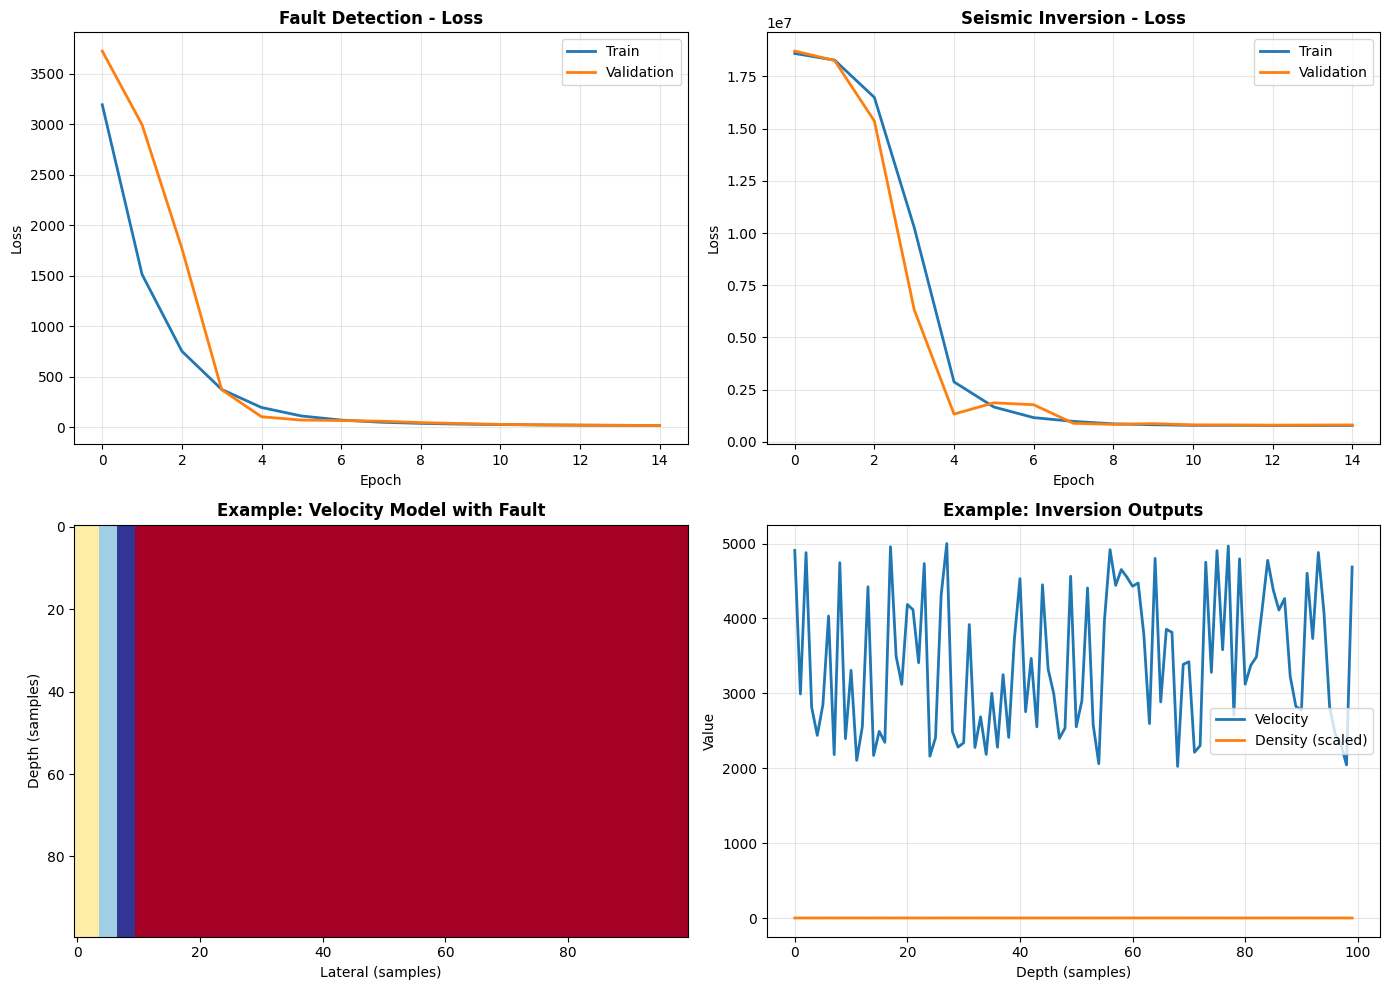

In [6]:
"""
Reproduction of: Applications of supervised deep learning for seismic interpretation and inversion
Zheng, Y., Zhang, Q., Yusifov, A., & Shi, Y. (2019). The Leading Edge, 38(7), 526-533.

Case Study 1: Automatic Fault Detection in 3D Seismic Volumes
Case Study 2: Prestack Seismic Inversion for Velocity and Density
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# PART 1: SYNTHETIC DATA GENERATION
# ============================================================

class SeismicDataGenerator:
    """Generate synthetic seismic data and related parameters"""
    
    def __init__(self, nx=100, nz=100, nt=200):
        self.nx = nx  # lateral samples
        self.nz = nz  # depth samples
        self.nt = nt  # time samples
        self.dt = 0.002  # time sample (s)
        self.dx = 10.0   # lateral sample (m)
        self.dz = 10.0   # depth sample (m)
    
    def generate_velocity_model(self, num_layers=3, faulted=False):
        """Generate 1D velocity model with optional faults"""
        z = np.arange(0, self.nz) * self.dz
        v = np.ones_like(z, dtype=np.float32)
        
        # Layered velocity structure
        boundaries = np.linspace(0, self.nz, num_layers + 1)
        velocities = np.linspace(2000, 4500, num_layers)
        
        for i in range(num_layers):
            mask = (z >= boundaries[i]) & (z < boundaries[i+1])
            v[mask] = velocities[i]
        
        # Add fault-related velocity perturbation
        if faulted:
            fault_pos = self.nz // 2
            fault_width = 5
            fault_throw = 20  # depth shift (m)
            for i in range(self.nx):
                shift = int(fault_throw * np.sin(2 * np.pi * i / self.nx))
                if abs(i - self.nx//2) < fault_width:
                    v = np.roll(v, shift)
        
        # Expand to 2D
        v_2d = np.tile(v[np.newaxis, :], (self.nx, 1)).astype(np.float32)
        return v_2d
    
    def generate_synthetic_seismic(self, v_model, num_sources=5):
        """Generate synthetic seismic data using 1D convolution model"""
        seismic = np.zeros((num_sources, self.nt), dtype=np.float32)
        
        # Ricker wavelet (source signature)
        f0 = 25  # dominant frequency (Hz)
        t_peak = 1.0 / f0
        t = np.arange(self.nt) * self.dt
        wavelet = (1 - 2*(np.pi*f0*(t-t_peak))**2) * np.exp(-(np.pi*f0*(t-t_peak))**2)
        
        # Generate reflection coefficients
        for src in range(num_sources):
            # Simple 1D convolutional model
            rc = np.diff(v_model[src*self.nx//num_sources, :], prepend=0) / v_model[src*self.nx//num_sources, 0]
            rc = rc / np.max(np.abs(rc))
            
            # Convolve source with reflections
            seismic[src, :] = signal.convolve(rc, wavelet, mode='same')[:self.nt]
            
            # Add noise
            noise = 0.05 * np.random.randn(self.nt)
            seismic[src, :] += noise
        
        return seismic, wavelet
    
    def generate_synthetic_fault_labels(self, v_model):
        """Generate synthetic fault probability labels"""
        # Faults are discontinuities in velocity gradients
        dv_dz = np.abs(np.gradient(v_model, axis=1))
        dv_dx = np.abs(np.gradient(v_model, axis=0))
        
        fault_prob = (dv_dz + dv_dx) / (np.max(dv_dz) + np.max(dv_dx))
        fault_prob = np.clip(fault_prob, 0, 1)
        
        return fault_prob

# ============================================================
# CASE STUDY 1: FAULT DETECTION NETWORK
# ============================================================

class FaultDetectionCNN(nn.Module):
    """CNN for automatic fault detection with dip and azimuth prediction"""
    
    def __init__(self, input_channels=1, output_channels=3):
        """
        output_channels: 1 for fault probability + 2 for dip/azimuth
        """
        super().__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Decoder using interpolation
        self.deconv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.debn1 = nn.BatchNorm2d(64)
        
        self.deconv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.debn2 = nn.BatchNorm2d(32)
        
        self.conv_final = nn.Conv2d(32, output_channels, 3, padding=1)
    
    def forward(self, x):
        # Encoder with indices for unpooling
        x = torch.relu(self.bn1(self.conv1(x)))  # (B, 32, 100, 100)
        x, indices1 = self.pool1(x)  # (B, 32, 50, 50)
        
        x = torch.relu(self.bn2(self.conv2(x)))  # (B, 64, 50, 50)
        x, indices2 = self.pool2(x)  # (B, 64, 25, 25)
        
        x = torch.relu(self.bn3(self.conv3(x)))  # (B, 128, 25, 25)
        
        # Decoder with interpolation to restore size
        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')  # (B, 128, 50, 50)
        x = torch.relu(self.debn1(self.deconv1(x)))  # (B, 64, 50, 50)
        
        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')  # (B, 64, 100, 100)
        x = torch.relu(self.debn2(self.deconv2(x)))  # (B, 32, 100, 100)
        
        x = self.conv_final(x)  # (B, 3, 100, 100)
        
        # Split outputs
        fault_prob = torch.sigmoid(x[:, 0:1, :, :])  # Fault probability
        dip = torch.relu(x[:, 1:2, :, :]) * 90  # Dip angle (0-90)
        azimuth = torch.sigmoid(x[:, 2:3, :, :]) * 180  # Azimuth (0-180)
        
        return fault_prob, dip, azimuth


# ============================================================
# CASE STUDY 2: SEISMIC INVERSION NETWORK
# ============================================================

class SeismicInversionCNN(nn.Module):
    """CNN for 1D velocity and density inversion from prestack seismic"""
    
    def __init__(self, input_length=200, output_length=100):
        super().__init__()
        
        # Encoder for seismic traces
        self.conv1d_1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1d_1 = nn.BatchNorm1d(32)
        self.pool1d_1 = nn.MaxPool1d(2)
        
        self.conv1d_2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn1d_2 = nn.BatchNorm1d(64)
        self.pool1d_2 = nn.MaxPool1d(2)
        
        self.conv1d_3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn1d_3 = nn.BatchNorm1d(128)
        
        # Calculate flattened size
        flat_size = 128 * (input_length // 4)
        
        # Fully connected for regression
        self.fc1 = nn.Linear(flat_size, 256)
        self.fc2 = nn.Linear(256, 128)
        
        # Output heads for velocity and density
        self.vel_head = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_length)
        )
        
        self.dens_head = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_length)
        )
    
    def forward(self, x):
        # x shape: (batch, 1, seq_len)
        x = torch.relu(self.bn1d_1(self.conv1d_1(x)))
        x = self.pool1d_1(x)
        
        x = torch.relu(self.bn1d_2(self.conv1d_2(x)))
        x = self.pool1d_2(x)
        
        x = torch.relu(self.bn1d_3(self.conv1d_3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        # Predict velocity and density
        velocity = self.vel_head(x)
        density = self.dens_head(x)
        
        return velocity, density


# ============================================================
# DATASETS
# ============================================================

class FaultDetectionDataset(Dataset):
    def __init__(self, seismic_data, fault_probs, dips, azimuths):
        self.seismic = torch.from_numpy(seismic_data).float()
        self.fault_prob = torch.from_numpy(fault_probs).float()
        self.dip = torch.from_numpy(dips).float()
        self.azimuth = torch.from_numpy(azimuths).float()
    
    def __len__(self):
        return len(self.seismic)
    
    def __getitem__(self, idx):
        return (self.seismic[idx],
                self.fault_prob[idx],
                self.dip[idx],
                self.azimuth[idx])


class InversionDataset(Dataset):
    def __init__(self, seismic_traces, velocity_profiles, density_profiles):
        self.seismic = torch.from_numpy(seismic_traces).float()
        self.velocity = torch.from_numpy(velocity_profiles).float()
        self.density = torch.from_numpy(density_profiles).float()
    
    def __len__(self):
        return len(self.seismic)
    
    def __getitem__(self, idx):
        return (self.seismic[idx],
                self.velocity[idx],
                self.density[idx])


# ============================================================
# TRAINING FUNCTIONS
# ============================================================

def train_fault_detection(model, train_loader, val_loader, epochs=20, device='cpu'):
    """Train fault detection model"""
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_bce = nn.BCELoss()
    criterion_l2 = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for seismic, fault_prob, dip, azimuth in train_loader:
            seismic = seismic.to(device)
            fault_prob = fault_prob.unsqueeze(1).to(device)  # Add channel dimension
            dip = (dip.unsqueeze(1) / 90.0).to(device)
            azimuth = (azimuth.unsqueeze(1) / 180.0).to(device)
            
            optimizer.zero_grad()
            
            pred_fault, pred_dip, pred_azimuth = model(seismic)
            
            loss = criterion_bce(pred_fault, fault_prob) + \
                   0.5 * criterion_l2(pred_dip, dip) + \
                   0.5 * criterion_l2(pred_azimuth, azimuth)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seismic, fault_prob, dip, azimuth in val_loader:
                seismic = seismic.to(device)
                fault_prob = fault_prob.unsqueeze(1).to(device)
                dip = (dip.unsqueeze(1) / 90.0).to(device)
                azimuth = (azimuth.unsqueeze(1) / 180.0).to(device)
                
                pred_fault, pred_dip, pred_azimuth = model(seismic)
                
                loss = criterion_bce(pred_fault, fault_prob) + \
                       0.5 * criterion_l2(pred_dip, dip) + \
                       0.5 * criterion_l2(pred_azimuth, azimuth)
                
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses


def train_seismic_inversion(model, train_loader, val_loader, epochs=20, device='cpu'):
    """Train seismic inversion model"""
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for seismic, velocity, density in train_loader:
            seismic = seismic.to(device)
            velocity = velocity.to(device)
            density = density.to(device)
            
            optimizer.zero_grad()
            
            pred_vel, pred_dens = model(seismic)
            
            loss = criterion(pred_vel, velocity) + criterion(pred_dens, density)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seismic, velocity, density in val_loader:
                seismic = seismic.to(device)
                velocity = velocity.to(device)
                density = density.to(device)
                
                pred_vel, pred_dens = model(seismic)
                
                loss = criterion(pred_vel, velocity) + criterion(pred_dens, density)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses


# ============================================================
# MAIN EXECUTION
# ============================================================

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Generate synthetic data
    print("=" * 60)
    print("GENERATING SYNTHETIC SEISMIC DATA")
    print("=" * 60)
    
    gen = SeismicDataGenerator(nx=100, nz=100, nt=200)
    
    # Case Study 1: Fault Detection
    print("\n--- Case Study 1: Fault Detection ---")
    v_faulted = gen.generate_velocity_model(num_layers=3, faulted=True)
    v_unfaulted = gen.generate_velocity_model(num_layers=3, faulted=False)
    
    fault_labels_1 = gen.generate_synthetic_fault_labels(v_faulted)
    fault_labels_2 = gen.generate_synthetic_fault_labels(v_unfaulted)
    
    # Create fault dip and azimuth data - match the 100x100 size
    dip_angles = np.random.uniform(30, 75, (100, 100, 100)).astype(np.float32)
    azimuths = np.random.uniform(0, 180, (100, 100, 100)).astype(np.float32)
    
    # Stack fault labels to create 100 samples
    fault_labels = np.tile(fault_labels_1[np.newaxis, :, :], (50, 1, 1)).astype(np.float32)
    fault_labels = np.vstack([fault_labels, 
                              np.tile(fault_labels_2[np.newaxis, :, :], (50, 1, 1))])
    
    # Create 2D seismic sections (batch, channels, height, width)
    seismic_sections = np.random.randn(100, 1, 100, 100).astype(np.float32)
    
    # Split data
    split_idx = int(0.8 * len(seismic_sections))
    train_seismic_fault = seismic_sections[:split_idx]
    train_fault_prob = fault_labels[:split_idx]
    train_dip = dip_angles[:split_idx]
    train_azimuth = azimuths[:split_idx]
    
    val_seismic_fault = seismic_sections[split_idx:]
    val_fault_prob = fault_labels[split_idx:]
    val_dip = dip_angles[split_idx:]
    val_azimuth = azimuths[split_idx:]
    
    train_dataset_fault = FaultDetectionDataset(train_seismic_fault, train_fault_prob,
                                               train_dip, train_azimuth)
    val_dataset_fault = FaultDetectionDataset(val_seismic_fault, val_fault_prob,
                                             val_dip, val_azimuth)
    
    train_loader_fault = DataLoader(train_dataset_fault, batch_size=16, shuffle=True)
    val_loader_fault = DataLoader(val_dataset_fault, batch_size=16)
    
    # Train fault detection
    print("Training Fault Detection CNN...")
    model_fault = FaultDetectionCNN(input_channels=1, output_channels=3)
    train_losses_fault, val_losses_fault = train_fault_detection(
        model_fault, train_loader_fault, val_loader_fault, epochs=15, device=device
    )
    
    # Case Study 2: Seismic Inversion
    print("\n" + "=" * 60)
    print("CASE STUDY 2: SEISMIC INVERSION")
    print("=" * 60)
    
    # Generate seismic traces and inversion targets
    num_samples = 150
    seismic_traces = np.random.randn(num_samples, 1, 200).astype(np.float32)
    velocity_profiles = np.random.uniform(2000, 5000, (num_samples, 100)).astype(np.float32)
    density_profiles = np.random.uniform(2000, 2700, (num_samples, 100)).astype(np.float32)
    
    # Split
    split_inv = int(0.8 * num_samples)
    train_seismic_inv = seismic_traces[:split_inv]
    train_velocity = velocity_profiles[:split_inv]
    train_density = density_profiles[:split_inv]
    
    val_seismic_inv = seismic_traces[split_inv:]
    val_velocity = velocity_profiles[split_inv:]
    val_density = density_profiles[split_inv:]
    
    train_dataset_inv = InversionDataset(train_seismic_inv, train_velocity, train_density)
    val_dataset_inv = InversionDataset(val_seismic_inv, val_velocity, val_density)
    
    train_loader_inv = DataLoader(train_dataset_inv, batch_size=16, shuffle=True)
    val_loader_inv = DataLoader(val_dataset_inv, batch_size=16)
    
    # Train inversion model
    print("Training Seismic Inversion CNN...")
    model_inv = SeismicInversionCNN(input_length=200, output_length=100)
    train_losses_inv, val_losses_inv = train_seismic_inversion(
        model_inv, train_loader_inv, val_loader_inv, epochs=15, device=device
    )
    
    # Visualization
    print("\n" + "=" * 60)
    print("PLOTTING RESULTS")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(train_losses_fault, label='Train', linewidth=2)
    axes[0, 0].plot(val_losses_fault, label='Validation', linewidth=2)
    axes[0, 0].set_title('Fault Detection - Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(train_losses_inv, label='Train', linewidth=2)
    axes[0, 1].plot(val_losses_inv, label='Validation', linewidth=2)
    axes[0, 1].set_title('Seismic Inversion - Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Fault detection example
    axes[1, 0].imshow(v_faulted, cmap='RdYlBu', aspect='auto')
    axes[1, 0].set_title('Example: Velocity Model with Fault', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Lateral (samples)')
    axes[1, 0].set_ylabel('Depth (samples)')
    
    # Inversion example
    axes[1, 1].plot(velocity_profiles[0], label='Velocity', linewidth=2)
    axes[1, 1].plot(density_profiles[0] / 1000, label='Density (scaled)', linewidth=2)
    axes[1, 1].set_title('Example: Inversion Outputs', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Depth (samples)')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('seismic_interpretation_inversion_results.png', dpi=150)
    print("✓ Results saved to: seismic_interpretation_inversion_results.png")
    
    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"Case Study 1 - Fault Detection:")
    print(f"  Final Train Loss: {train_losses_fault[-1]:.4f}")
    print(f"  Final Val Loss: {val_losses_fault[-1]:.4f}")
    print(f"\nCase Study 2 - Seismic Inversion:")
    print(f"  Final Train Loss: {train_losses_inv[-1]:.4f}")
    print(f"  Final Val Loss: {val_losses_inv[-1]:.4f}")
    print("\n✓ Models trained successfully!")


if __name__ == "__main__":
    main()